In [1]:
!pip install joblib

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

import glob
import time
import cv2
import re

from sklearn.utils import shuffle

from training import *
from detection import *

%matplotlib inline

def numericalSort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])

    return parts

In [3]:
from feature import *

cars, notcars = list_files(data_dir='./data')

print("Original - Car image count: {}, non-car image count: {}".format(len(cars), len(notcars)))

Original - Car image count: 8792, non-car image count: 8968


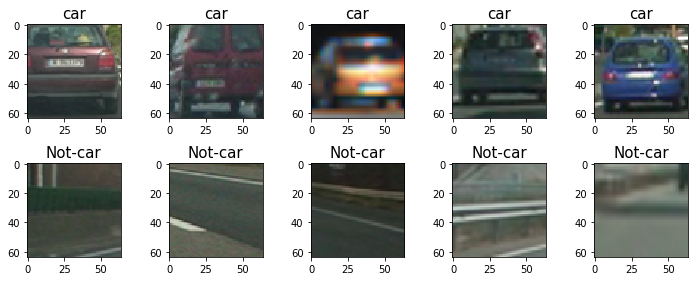

In [4]:
def show_sample(cars, notcars):
    r, c = (2, 5)
    
    f, ax = plt.subplots(r, c, figsize=(10, 4))
    f.tight_layout()
    
    ax = ax.ravel()

    # Make it reproducible
    np.random.seed(1)
    
    for i in range(0, c):
        idx = np.random.randint(0, 2000)

        ax[i].imshow(mpimg.imread(cars[idx]))
        ax[i].set_title("car", fontsize=15)

        ax[c + i].imshow(mpimg.imread(notcars[idx]))
        ax[c + i].set_title('Not-car', fontsize=15)
    
    plt.savefig('./output_images/car_not_car.png')
    plt.show()
    
show_sample(cars, notcars)

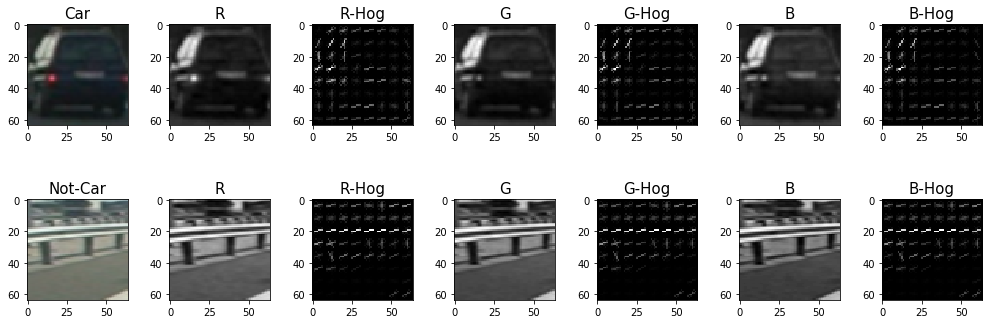

In [5]:
from feature import *

params = Params(color_space='YCrCb', hog_feat=True)

def show_hog_feature_sample(color_space, params):    
    car_image = mpimg.imread(cars[1150])
    notcar_image = mpimg.imread(notcars[1150])
    
    r, c = (2, 7)

    f, ax = plt.subplots(r, c, figsize=(14, 5))
    f.tight_layout()

    ax = ax.ravel()
    
    for i, img, title in zip(range(0, 2), [car_image, notcar_image], ['Car', 'Not-Car']):
        ax[i * c].imshow(img)
        ax[i * c].set_title(title, fontsize=15)
        
        img = convert_color_space(img, ''.join(color_space))
        
        for channel in range(0, 3):
            channel_image = img[:,:,channel]
            
            ax[i*c + channel*2 + 1].imshow(channel_image, cmap='gray')
            ax[i*c + channel*2 + 1].set_title("{}".format(color_space[channel]), fontsize=15)
            
            _, hog_image = get_hog_features(channel_image, orient=params.orient, 
                                         pix_per_cell=params.pix_per_cell,
                                         cell_per_block=params.cell_per_block,
                                         vis=True, feature_vec=True)
            ax[i*c + channel*2 + 2].imshow(hog_image, cmap='gray')
            ax[i*c + channel*2 + 2].set_title("{}-Hog".format(color_space[channel]), fontsize=15)
            
    plt.savefig('./output_images/HOG_{}.jpg'.format(''.join(color_space)))

show_hog_feature_sample(color_space=['R', 'G', 'B'], params=params)

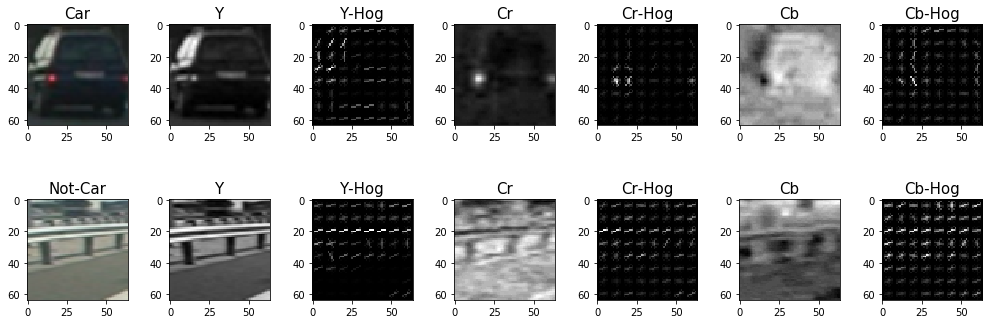

In [6]:
show_hog_feature_sample(color_space=['Y', 'Cr', 'Cb'], params=params)

In [7]:
params = Params(color_space='YCrCb', hog_feat=True)

X_train, X_test, y_train, y_test = prepare_dataset(cars, notcars, params, ratio=0.2)
X_scaler, X_train, X_test = normalize(X_train, X_test)

print('Using:', params.orient,'orientations', params.pix_per_cell, 
      'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t=time.time()
svc = train_svc_model(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1991s.) Setting batch_size=2.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1205s.) Setting batch_size=6.
[Parallel(n_jobs=10)]: Done  63 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Batch computation too fast (0.1802s.) Setting batch_size=12.
[Parallel(n_jobs=10)]: Done 105 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 184 tasks      | elapsed:    2.5s
[Parallel(n_jobs=10)]: Done 364 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 544 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done 748 tasks      | elapsed:

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
9.5 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


In [32]:
car_detector = CarDetector(params, svc, X_scaler, scales=[1.0])

test_images = sorted(glob.glob('./test_images/test*.jpg'), key=numericalSort)

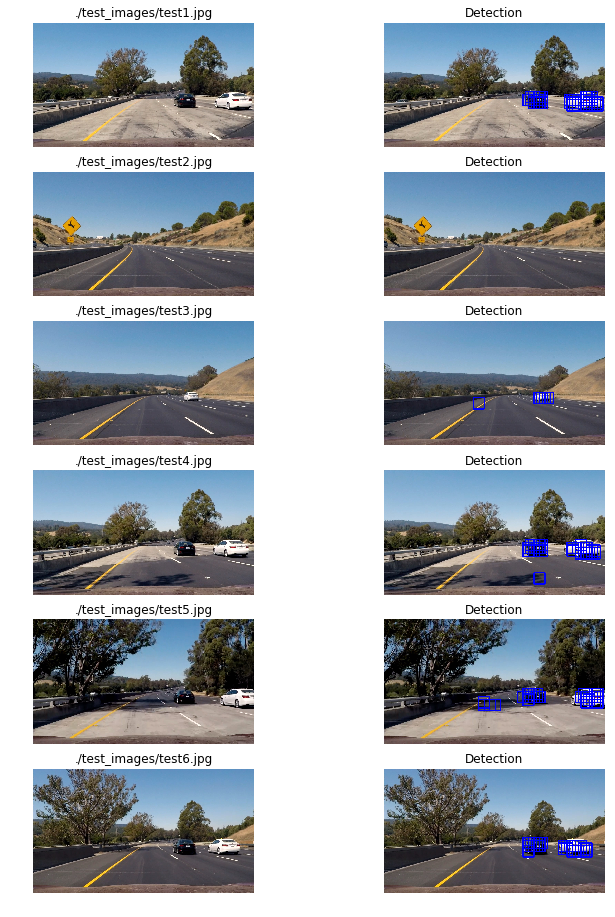

In [33]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def demo_find_cars(car_detector):
    fig, axs = plt.subplots(6, 2, figsize=(12,16))
    fig.subplots_adjust(hspace =.2, wspace=.1)
    axs = axs.ravel()

    for i, im in enumerate(test_images):
        image = read_image(im)
        bboxes = car_detector.search_cars(image)        
        image_w_box = draw_boxes(image, bboxes)

        axs[i * 2].imshow(image)
        axs[i * 2].set_title(im)
        axs[i * 2].axis('off')

        axs[i * 2 + 1].imshow(image_w_box)
        axs[i * 2 + 1].set_title('Detection')
        axs[i * 2 + 1].axis('off')

    plt.savefig('./output_images/pipeline.jpg')
    plt.show()
    
demo_find_cars(car_detector)

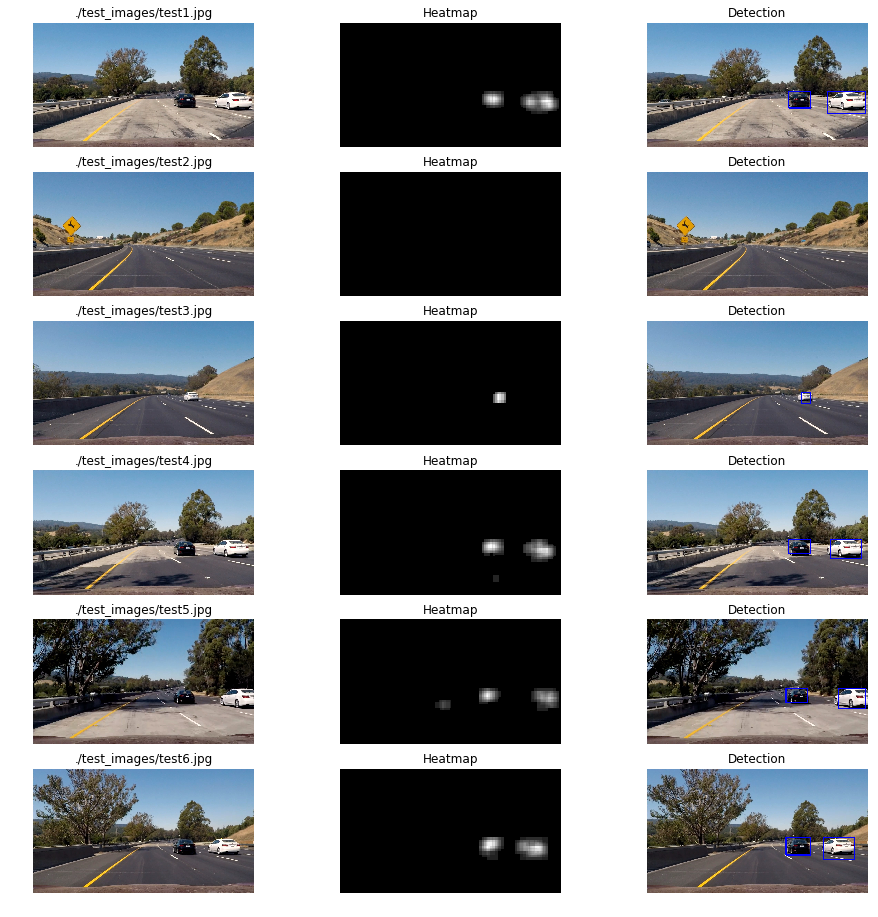

In [22]:
scales = [ 0.8, 1.0, 2.0]
car_detector = CarDetector(params, svc, X_scaler, scales=scales)

def demo_detection(car_detector):
    fig, axs = plt.subplots(6, 3, figsize=(16,16))
    fig.subplots_adjust(hspace =.2, wspace=.1)
    axs = axs.ravel()

    for i, im in enumerate(test_images):
        image = read_image(im)
        heatmap = car_detector.generate_heatmap(image)
        labels = car_detector.find_labels(heatmap)
        detected = draw_labeled_bboxes(np.copy(image), labels)

        axs[i * 3].imshow(image)
        axs[i * 3].set_title(im)
        axs[i * 3].axis('off')

        axs[i * 3 + 1].imshow(heatmap, cmap='gray')
        axs[i * 3 + 1].set_title('Heatmap')
        axs[i * 3 + 1].axis('off')

        axs[i * 3 + 2].imshow(detected)
        axs[i * 3 + 2].set_title('Detection')
        axs[i * 3 + 2].axis('off')

    plt.savefig('./output_images/detection.jpg')
    plt.show()
    
demo_detection(car_detector)

In [23]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
car_detector = CarDetector(params, svc, X_scaler, scales)

output = 'test_result.mp4'
clip = VideoFileClip("test_video.mp4")
video_clip = clip.fl_image(car_detector.detect_cars)
%time video_clip.write_videofile(output, audio=False)

In [25]:
output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(25,30)
video_clip = clip.fl_image(car_detector.detect_cars)
%time video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [20:48<00:00,  1.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 1min 8s, sys: 4.38 s, total: 1min 12s
Wall time: 20min 49s
